# Check predictions for synthesized compounds

395 compounds that we have attempted to synthesize are also contained in the VL. We want to check how well the predictions overlap with the measurements

In this notebook, we only import the compounds that are both synthesized and in VL from a file. That file was originally created from the `virtual_library_frontend.ipynb` but I removed the code there, as that does not fits that notebooks primary purpose. For reproducibility, the code block is given here:
```python
# find a whole bunch of compounds in the VL
queries = [smi.split(">>")[1] for smi in pd.read_csv("../data/reactionSMILESunbalanced_LCMS_2022-08-25.csv")["SMILES"].values.tolist()]

found = []
found_smiles = []
for query in queries:
    canonical_query = canonicalize_smiles(query)
    try:
        mol_number = int(df_allsmiles.loc[df_allsmiles["smiles"] == canonical_query, "mol_number"])
        found.append(mol_number)
        found_smiles.append(query)
    except TypeError:
        #print("The input SMILES was not found in the virtual library")
        pass

found = sorted(set(found))
found_smiles = df_allsmiles.loc[df_allsmiles["mol_number"].isin(found), "smiles"].values.tolist()
pd.DataFrame([*zip(found, found_smiles)], columns=["mol_number", "smiles"]).to_csv("../data/synthesized_compounds_in_vl.csv", index=False)
```

In [120]:
import pathlib
import pandas as pd
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from src.util.rdkit_util import canonicalize_smiles

In [12]:
vl_dir = pathlib.Path("../data/VL/")

In [5]:
synthesized_vl_members = pd.read_csv("../data/synthesized_compounds_in_vl.csv")
synthesized_vl_members

,mol_number,smiles
0,33970,CCC(CC)C1COCC(c2ccc(C(F)(F)F)cc2)N1
1,34492,Clc1ccc(C2COCC(c3cccc(Br)c3)N2)cc1Cl
2,70282,CCOC(=O)N1CC(c2nccs2)NC(C2CCOCC2)C1
3,156658,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F
4,226399,CCOC(=O)N1CC(c2ccc(O)cc2)NC(C2CCCCC2)C1
...,...,...
388,17281673,Cc1ccc(C2COCC(c3ccc(C(C)(C)C)cc3)N2)cc1
389,17346743,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1
390,17416302,Cn1cc(C2COCC(c3ccc4ccccc4c3)N2)cn1
391,17454694,Cc1ccc(C2COCC(c3cccnc3)N2)cc1


In [6]:
# determine which chunk the data we are looking for is in
synthesized_vl_members["chunk"] = synthesized_vl_members["mol_number"] // 10000

In [7]:
synthesized_vl_members

,mol_number,smiles,chunk
0,33970,CCC(CC)C1COCC(c2ccc(C(F)(F)F)cc2)N1,3
1,34492,Clc1ccc(C2COCC(c3cccc(Br)c3)N2)cc1Cl,3
2,70282,CCOC(=O)N1CC(c2nccs2)NC(C2CCOCC2)C1,7
3,156658,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,15
4,226399,CCOC(=O)N1CC(c2ccc(O)cc2)NC(C2CCCCC2)C1,22
...,...,...,...
388,17281673,Cc1ccc(C2COCC(c3ccc(C(C)(C)C)cc3)N2)cc1,1728
389,17346743,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1,1734
390,17416302,Cn1cc(C2COCC(c3ccc4ccccc4c3)N2)cn1,1741
391,17454694,Cc1ccc(C2COCC(c3cccnc3)N2)cc1,1745


In [17]:
# read only the file for the relevant chunk
df_compound_list = []
for chunk in synthesized_vl_members["chunk"].unique():
    df_props = pd.read_csv(vl_dir / f"VL_chunk_{chunk:04}.csv.bz2")
    # extract the queried compounds
    for mol_number in synthesized_vl_members.loc[synthesized_vl_members["chunk"] == chunk, "mol_number"]:
        df_compound = df_props.loc[df_props["mol_number"] == mol_number]
        df_compound_list.append(df_compound)

In [19]:
df_pred = pd.concat(df_compound_list)

In [21]:
# now import the measured data
# start with properties
df_props = pd.read_csv("../data/Data S3 - clean_novartis_2022-08-25.csv")

In [38]:
df_props.loc[df_props["Structure"].isna(), "Structure"] = ""

In [39]:
smiles = []
for structure in df_props["Structure"]:
    smiles.append(canonicalize_smiles(structure.replace("@", "")))

In [41]:
df_props["smiles"] = smiles

In [47]:
merged = df_pred.merge(df_props, on="smiles", how="left")

In [67]:
merged["predicted_Solubility_pH6.8_(mM)"] = 10 ** merged["predicted_logSolubility_pH6.8_(mM)"]
merged["High Throughput Equilibrium logSolubility pH 6.8 (mM)"] = np.log10(merged["High Throughput Equilibrium Solubility pH 6.8 (mM)"])

In [69]:
# check solubility predictions
df_sol = merged.dropna(subset=["predicted_Solubility_pH6.8_(mM)", "High Throughput Equilibrium Solubility pH 6.8 (mM)"])
df_sol[["smiles", "predicted_Solubility_pH6.8_(mM)", "High Throughput Equilibrium Solubility pH 6.8 (mM)"]]

,smiles,predicted_Solubility_pH6.8_(mM),High Throughput Equilibrium Solubility pH 6.8 (mM)
3,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,0.008235,0.004
4,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,0.008235,0.012
5,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,0.008235,0.004
6,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,0.008235,0.006
7,CCOC(=O)N1CC(c2ccc(O)cc2)NC(C2CCCCC2)C1,0.240490,0.246
...,...,...,...
499,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1,0.068172,0.115
500,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1,0.068172,0.750
501,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1,0.068172,0.089
504,COC(=O)c1ccc(C2COCC(c3ccc(Cl)cc3)N2)cc1,0.014373,0.004


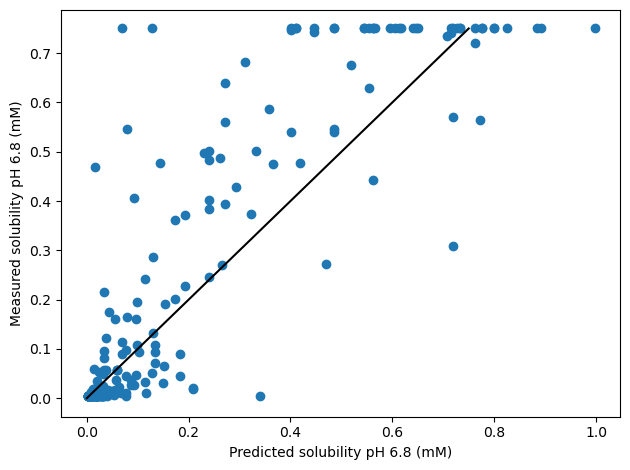

In [156]:
fig, ax = plt.subplots()
ax.scatter(df_sol["predicted_Solubility_pH6.8_(mM)"], df_sol["High Throughput Equilibrium Solubility pH 6.8 (mM)"])
ax.plot([0, 0.75], [0, 0.75], "black")
ax.set_xlabel("Predicted solubility pH 6.8 (mM)")
ax.set_ylabel("Measured solubility pH 6.8 (mM)")
fig.tight_layout()


In [71]:
r2_score(df_sol["High Throughput Equilibrium Solubility pH 6.8 (mM)"], df_sol["predicted_Solubility_pH6.8_(mM)"])

0.7909315840514685

In [116]:
# MAE
mean_absolute_error(df_sol["High Throughput Equilibrium Solubility pH 6.8 (mM)"], df_sol["predicted_Solubility_pH6.8_(mM)"])

0.06969326581127466

In [117]:
# RMSE
np.sqrt(mean_squared_error(df_sol["High Throughput Equilibrium Solubility pH 6.8 (mM)"], df_sol["predicted_Solubility_pH6.8_(mM)"]))

0.12974501064633948

<AxesSubplot:xlabel='predicted_logSolubility_pH6.8_(mM)', ylabel='High Throughput Equilibrium logSolubility pH 6.8 (mM)'>

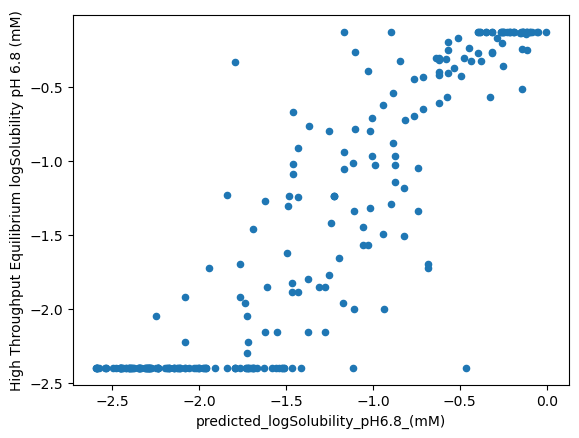

In [119]:
# look at the same thing again but in logarithm
df_sol[["smiles", "predicted_logSolubility_pH6.8_(mM)", "High Throughput Equilibrium logSolubility pH 6.8 (mM)"]].plot.scatter(x="predicted_logSolubility_pH6.8_(mM)", y="High Throughput Equilibrium logSolubility pH 6.8 (mM)")


In [74]:
# let's look at logD next
df_logd = merged.dropna(subset=["predicted_logD_pH7.4", "Direct logP/D in 1-octanol/buffer measure logD"])
df_logd[["smiles", "predicted_logD_pH7.4", "Direct logP/D in 1-octanol/buffer measure logD"]]

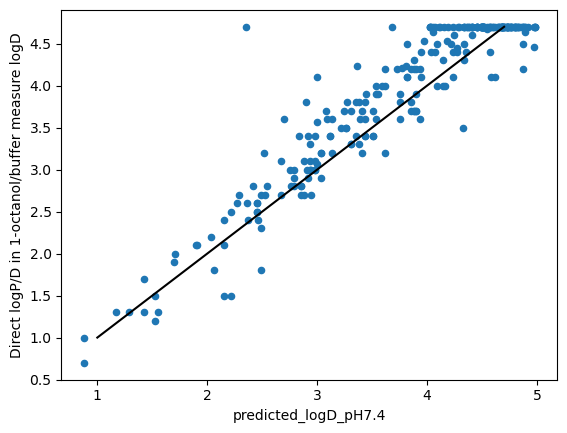

In [159]:
df_logd[["smiles", "predicted_logD_pH7.4", "Direct logP/D in 1-octanol/buffer measure logD"]].plot.scatter(x="predicted_logD_pH7.4", y="Direct logP/D in 1-octanol/buffer measure logD")
plt.plot([1, 4.7], [1, 4.7], "black")

In [79]:
r2_score(df_logd["Direct logP/D in 1-octanol/buffer measure logD"], df_logd["predicted_logD_pH7.4"])

0.8647081022582377

In [114]:
# MAE
mean_absolute_error(df_logd["Direct logP/D in 1-octanol/buffer measure logD"], df_logd["predicted_logD_pH7.4"])

0.25308722868597777

In [115]:
# RMSE
np.sqrt(mean_squared_error(df_logd["Direct logP/D in 1-octanol/buffer measure logD"], df_logd["predicted_logD_pH7.4"]))

0.34992014535517185

In [81]:
# and last, pKa
df_pka = merged.dropna(subset=["center1_pKa", "High-Throughput Ionization Constants pKa1"])
df_pka[["smiles", "center1_pKa", "High-Throughput Ionization Constants pKa1"]]

,smiles,center1_pKa,High-Throughput Ionization Constants pKa1
3,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,5.79,4.80000
4,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,5.79,5.00000
5,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,5.79,4.70000
6,N#Cc1cc(C2COCC(c3cc(Cl)cc(Cl)c3)N2)ccc1F,5.79,4.90000
7,CCOC(=O)N1CC(c2ccc(O)cc2)NC(C2CCCCC2)C1,10.26,7.53578
...,...,...,...
492,CC1(C)OCC(c2ccc(O)cc2)NC1c1ccc(Cl)c(Cl)c1,9.79,5.80000
496,CCOC(=O)N1CC(c2cccc(OC)c2)NC(C2CC2)C1,8.00,7.20772
497,CCOC(=O)N1CC(CC(C)C)NC(c2ccc(O)cc2)C1,10.26,7.66420
501,c1ccc(-c2ccc(C3COCC(C4CC4)N3)cc2)cc1,8.60,7.50000


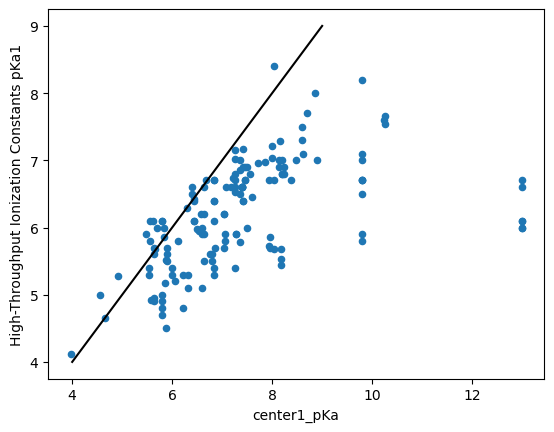

In [160]:
df_pka[["smiles", "center1_pKa", "High-Throughput Ionization Constants pKa1"]].plot.scatter(x="center1_pKa", y="High-Throughput Ionization Constants pKa1")
plt.plot([4, 9], [4, 9], "black")

In [84]:
r2_score(df_pka["High-Throughput Ionization Constants pKa1"], df_pka["center1_pKa"])

-4.680580451182803

In [112]:
# MAE
mean_absolute_error(df_pka["High-Throughput Ionization Constants pKa1"], df_pka["center1_pKa"])

1.2275826137254902

In [113]:
# RMSE
np.sqrt(mean_squared_error(df_pka["High-Throughput Ionization Constants pKa1"], df_pka["center1_pKa"]))

1.8457385033777085

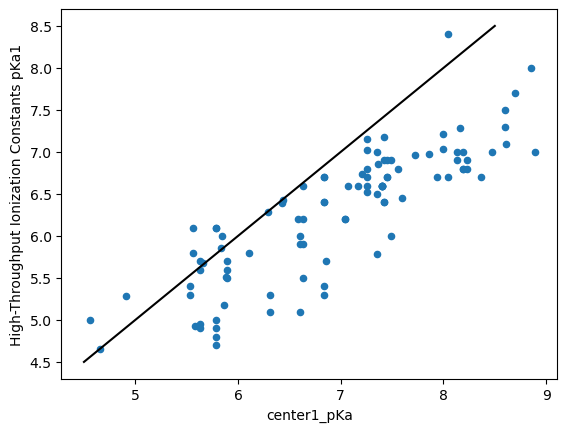

In [161]:
# this looks bad. We limit ourselves to compounds with just one ionizable center so we are sure we compare the right things
df_pka.loc[df_pka["center2_pKa"].isna()][["smiles", "center1_pKa", "High-Throughput Ionization Constants pKa1"]].plot.scatter(x="center1_pKa", y="High-Throughput Ionization Constants pKa1")
plt.plot([4.5, 8.5], [4.5, 8.5], "black")

In [95]:
r2_score(df_pka.loc[df_pka["center2_pKa"].isna()]["High-Throughput Ionization Constants pKa1"], df_pka.loc[df_pka["center2_pKa"].isna()]["center1_pKa"])

-0.23165520283033292

In [109]:
# MAE
mean_absolute_error(df_pka.loc[df_pka["center2_pKa"].isna()]["High-Throughput Ionization Constants pKa1"], df_pka.loc[df_pka["center2_pKa"].isna()]["center1_pKa"])

0.7244246514851485

In [111]:
# RMSE
np.sqrt(mean_squared_error(df_pka.loc[df_pka["center2_pKa"].isna()]["High-Throughput Ionization Constants pKa1"], df_pka.loc[df_pka["center2_pKa"].isna()]["center1_pKa"]))

0.8568069053136022

## Conclusion

#### Solubility

Solubility predictions are good. The metrics (even though very good) are a bit useless here as many compounds lying on the extreme end of the assay range. But looking at the scatter plot, it is clear, that the prediction is generally decent, and, crucially, there are very few compounds with high predicted solubility, that are not actually highly soluble.

#### Lipophilicity
logD predictions are very good with an MAE of 0.25 and RMSE of 0.35. The scatter plot corroborates that this fit is very good.

#### Ionizability 
pKa predictions are not good. Note that these are from MoKa, not Chemprop. Even when we limit our analysis to compounds with just one ionizable center (to make sure we don't accidentally compare different centers), the R2 is still negative (-0.23). The MAE (0.72) and RMSE (0.86) are  moderately high. The MoKa predictions are biased, mostly overestimating the pKa, but also have a high variance

<AxesSubplot:ylabel='Frequency'>

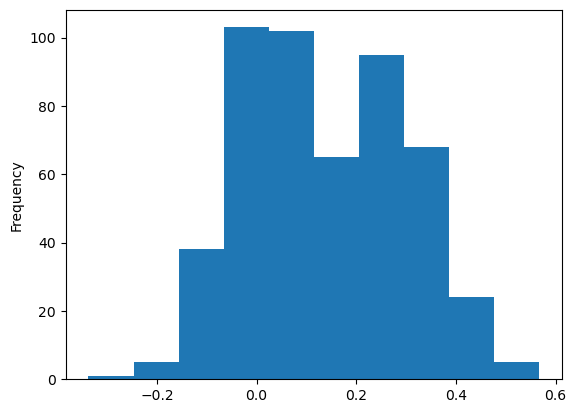

In [103]:
merged["predicted_ionization_constant"].plot.hist()

<AxesSubplot:xlabel='predicted_ionization_constant', ylabel='High-Throughput Ionization Constants pKa1'>

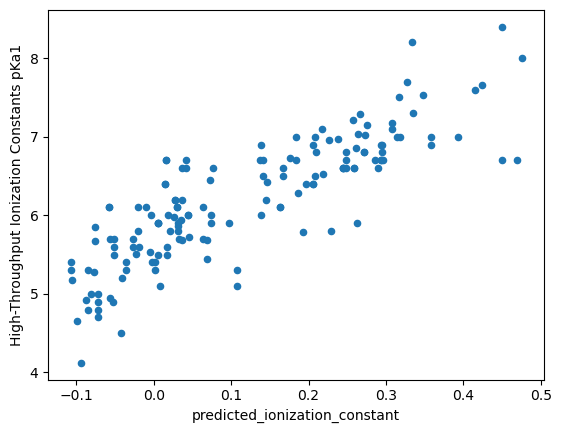

In [163]:
merged[["predicted_ionization_constant", "High-Throughput Ionization Constants pKa1"]].plot.scatter(x="predicted_ionization_constant", y="High-Throughput Ionization Constants pKa1")

In [105]:
merged["predicted_ionization_constant"].mean()


0.1382181525575411

In [106]:
merged["predicted_ionization_constant"].std()

0.1610186960316241

In [107]:
np.log10(0.13)

-0.8860566476931632